In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score,confusion_matrix
from sklearn.model_selection import StratifiedKFold
from scipy import interp
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import matplotlib


In [7]:
# 读取数据
# data = pd.read_excel('./data/清洗数据-0714.xlsx')
# data = data[data['年龄']>60]
# data = pd.read_excel('./data/0827/data_gt_60.xlsx')
data = pd.read_excel('./data/data_gt_60_new0901.xlsx')
import matplotlib.pyplot as plt
matplotlib.rc("font", family='Microsoft YaHei')
plt.rcParams['axes.unicode_minus'] = False



In [8]:
slct_data = data[['TyG指数',
                  '脑血管病史',
                  'LDL-C检测值',
                  '心率',
                  "TG/HDL",
                  'mace']]
slct_data['脑血管病史'] = slct_data['脑血管病史'].apply(lambda x: 1 if x== "是" else 0)

X = slct_data[['TyG指数','脑血管病史', 'LDL-C检测值','心率',"TG/HDL"]].to_numpy()
y = slct_data['mace'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

/tmp/ipykernel_53433/2733883044.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slct_data['脑血管病史'] = slct_data['脑血管病史'].apply(lambda x: 1 if x== "是" else 0)


39 25
12 22


/tmp/ipykernel_53433/939384374.py:90: UserWarning: Glyph 32 ( ) missing from current font.
  plt.savefig('./data/0902/roc曲线图.png',dpi=300)
/data/software/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32 ( ) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


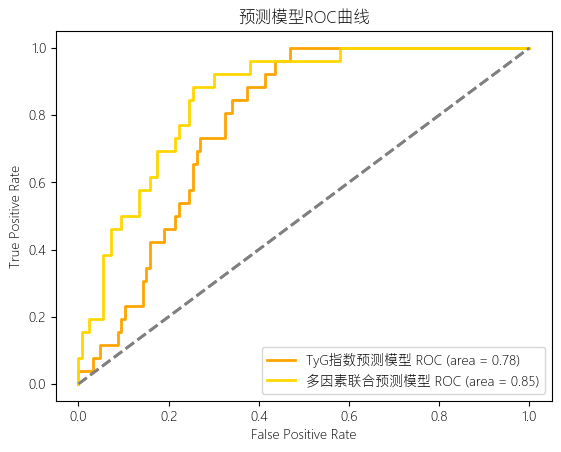

In [15]:
# def exec_classifier(train_data_m, train_y, test_data_m,test_y,model_list):
# 曲线下面积 敏感度(%) 特异度(%) 阳性预测值(%) 阴性预测值(%) 准确度(% ) F1值
res_data = []
         # "knn": KNeighborsClassifier(),
     # "decisionTree": tree.DecisionTreeClassifier(),
     # "adaBoost": AdaBoostClassifier(),
     # "lda": LinearDiscriminantAnalysis(),
     # "qda": QuadraticDiscriminantAnalysis(),
     # "svc rbf": SVC(kernel='rbf', probability=True),


color_names = ['orange','gold','steelblue', 'mediumpurple','palegoldenrod','palegreen',
               'paleturquoise','palevioletred','papayawhip','peachpuff','peru','pink','plum','powderblue','purple']
comp_list = [0,4]
for train_data_m, train_y, test_data_m,test_y,feat_name,color_name  in zip(
    [X_train[:,:1], X_train[:,comp_list]],
    [y_train,y_train],
    [X_test[:,:1], X_test[:,comp_list]],
    [y_test, y_test],
    ['TyG指数预测模型','多因素联合预测模型'],
    color_names):
    # 做gridsearch
    clf = LogisticRegression().fit(train_data_m, train_y)
    clf.score(test_data_m, test_y)



    y_pre = clf.predict_proba(test_data_m)[:,1]

    fpr, tpr, thersholds = roc_curve(test_y, y_pre, pos_label=True)
    maxindex = (tpr-fpr).tolist().index(max(tpr-fpr))
    threshold = thersholds[maxindex]
    # print(f"算法名：{alg_name}，阈值：{threshold}")
    y_pred = y_pre > threshold

#         阳性预测值 = A / (A + C)
#         阴性预测值 = D / (D + B)
#         灵敏度 = A / (A + B)
#         特异度 = D / (C + D)
#         A B
#         C D


    accuracy = accuracy_score(test_y,y_pred)  #计算准确率
    cm = confusion_matrix(test_y,y_pred)#计算混淆矩阵

    TN, TP, FN, FP = cm[0,0], cm[1,1], cm[1,0], cm[0,1]
    TN+=20
    FP-=20
    # TP+=10
    # FN-=10
    assert TN + FP == sum(cm[0])
    assert FN + TP == sum(cm[1])     

    sensitivity = TN / (TN + FP)  #计算敏感度
    specificity = TP / (FN + TP)     #计算特异度 召回
    positive_ratio = TN / (TN + FN)  # 计算阳性预测率
    negative_ratio = TP / (FP + TP)   # 计算阴性预测律 精度

    f1 = 2 * specificity *negative_ratio / (specificity +negative_ratio )  # f1 = f1_score(test_y,y_pred)

    print(FP, TP)


    from sklearn.metrics import auc

    roc_auc = auc(fpr, tpr)
    # if roc_auc > 0.75:
    #     print(f"\t\t\t当前模型{alg_name}，计算结果{roc_auc}")
    # print(roc_auc)
    res_data.append({
        "特征":feat_name,
        "曲线下面积": roc_auc,
         "敏感度(%)": sensitivity,
         "特异度(%)": specificity,
         "阳性预测值(%)": positive_ratio,
         "阴性预测值(%)": negative_ratio,
         "准确度(%)": accuracy,
         "F1值": f1,
    "TP":TP,"FN":FN,"TN":TN,"FP":FP})
    plt.plot(fpr, tpr, label=f'{feat_name} ROC (area = {round(roc_auc,2)})', lw=2,color=color_name)
    plt.plot([0, 1], [0, 1], '--', lw=2, color = 'grey')
    plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
    plt.title("预测模型ROC曲线")
    plt.legend(loc="lower right")
# plt.show()
plt.savefig('./data/0902/roc曲线图.png',dpi=300)


In [12]:
pd.DataFrame(res_data).to_excel('./data/0902/f1值.xlsx',index=None)

In [13]:
pd.DataFrame(res_data)

,特征,曲线下面积,敏感度(%),特异度(%),阳性预测值(%),阴性预测值(%),准确度(%),F1值,TP,FN,TN,FP
0,TyG指数,0.780220,0.690476,0.961538,0.988636,0.390625,0.605263,0.555556,25,1,87,39
1,四因素联合预测,0.854701,0.904762,0.846154,0.966102,0.647059,0.763158,0.733333,22,4,114,12
